In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

In [123]:
df = pd.read_csv('daily-website-visitors.csv', index_col = 'Date', parse_dates = True)
df.index.freq = 'D'
df

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582","1,430",152
2014-09-15,2,Monday,2,"3,621","2,528","2,297",231
2014-09-16,3,Tuesday,3,"3,698","2,630","2,352",278
2014-09-17,4,Wednesday,4,"3,667","2,614","2,327",287
2014-09-18,5,Thursday,5,"3,316","2,366","2,130",236
...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,"2,221","1,696","1,373",323
2020-08-16,2164,Sunday,1,"2,724","2,037","1,686",351
2020-08-17,2165,Monday,2,"3,456","2,638","2,181",457


### Data is in object type instead of int, have to get rid of comma after thousands

In [124]:
df['First.Time.Visits'] = df['First.Time.Visits'].str.replace(',', '')
df['First.Time.Visits'] = df['First.Time.Visits'].astype(int)

<AxesSubplot:xlabel='Date'>

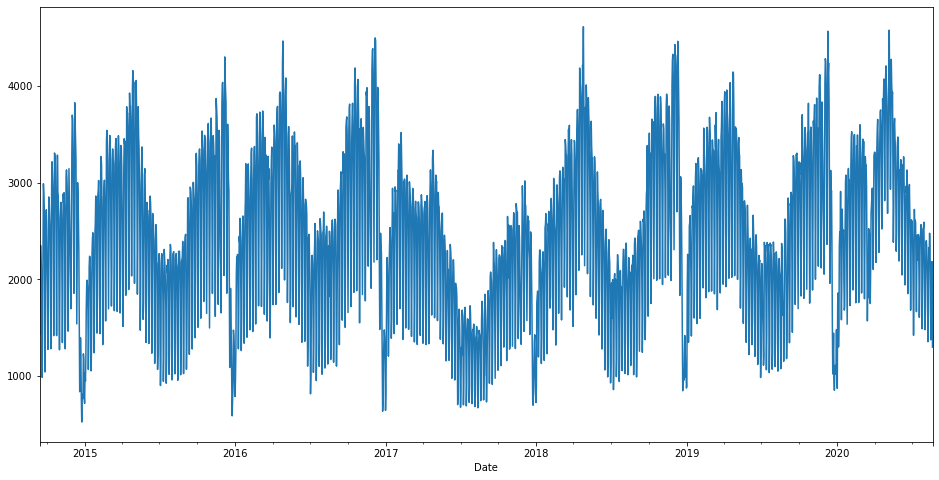

In [125]:
plt.rc("figure", figsize = (16, 8))
df['First.Time.Visits'].plot()

##### On first glance there seems to be yearly seasonality in the data

C:\Users\Rudy\AppData\Local\Temp/ipykernel_15492/3293344013.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  resultSeasonal = seasonal_decompose(df['First.Time.Visits'], freq = 365)


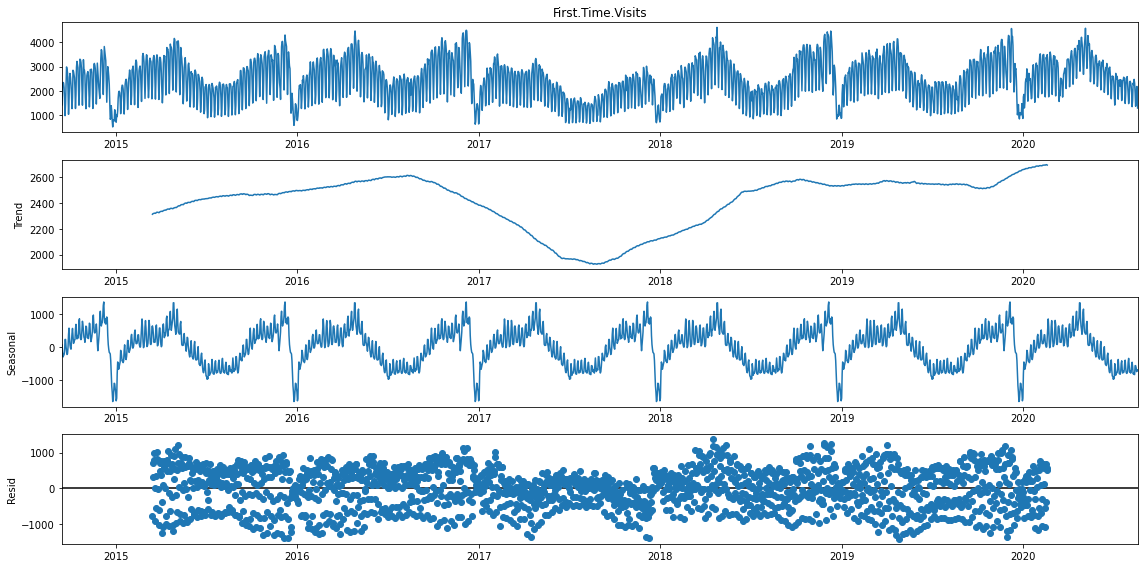

In [15]:
resultSeasonal = seasonal_decompose(df['First.Time.Visits'], freq = 365)
resultSeasonal.plot();

##### Not the best result, residuals are huge

### Resampling to remove the weekly seasonality

In [126]:
df1 = df['First.Time.Visits'].resample('W').mean()
df1

Date
2014-09-14    1430.000000
2014-09-21    1884.857143
2014-09-28    2231.571429
2014-10-05    2131.428571
2014-10-12    2300.142857
                 ...     
2020-07-26    2226.714286
2020-08-02    2138.714286
2020-08-09    2032.857143
2020-08-16    2051.857143
2020-08-23    1887.333333
Freq: W-SUN, Name: First.Time.Visits, Length: 311, dtype: float64

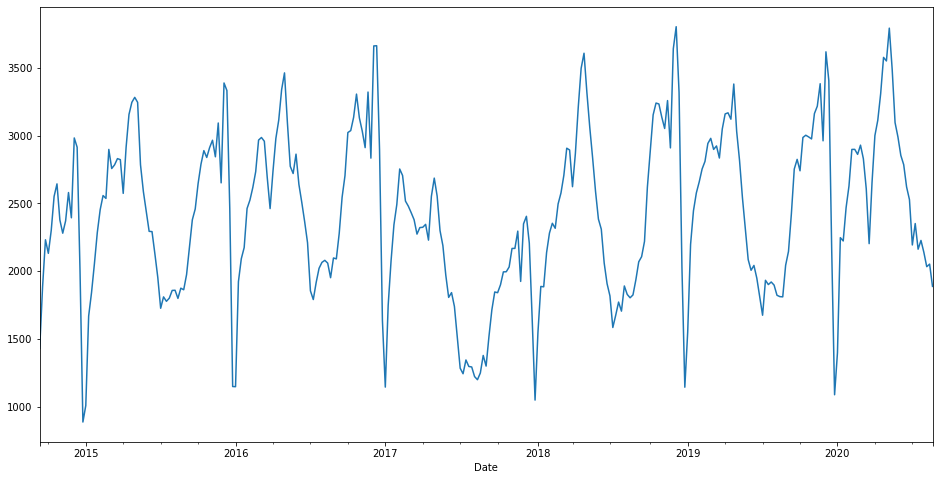

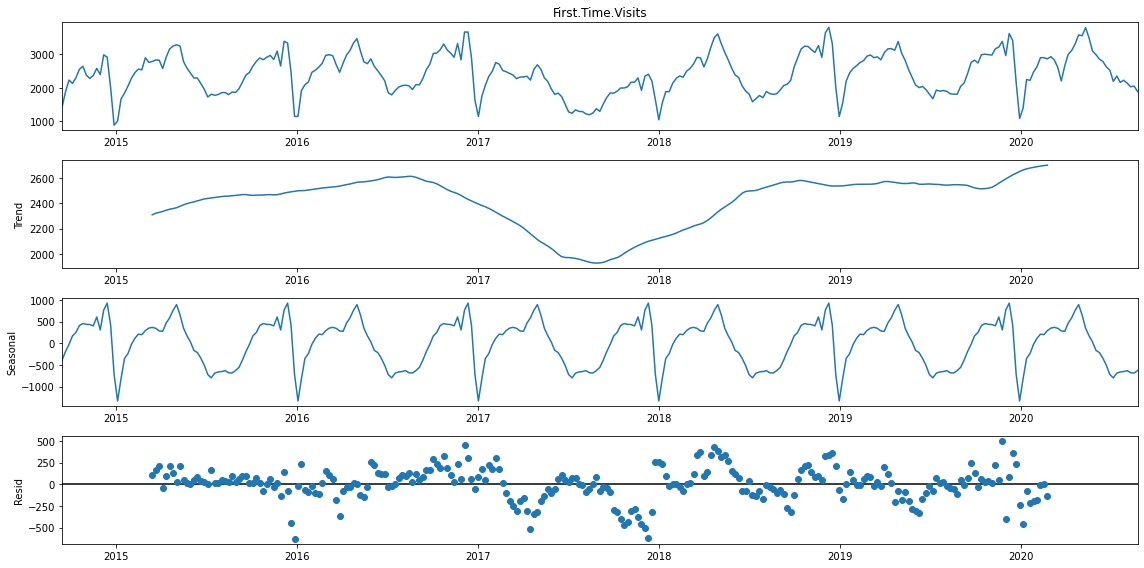

In [127]:
df1.plot()
resultSeasonal = seasonal_decompose(df1)
resultSeasonal.plot();

##### Looks better now, clear yearly seasonality

### Checking for another seasonality

<AxesSubplot:xlabel='Date'>

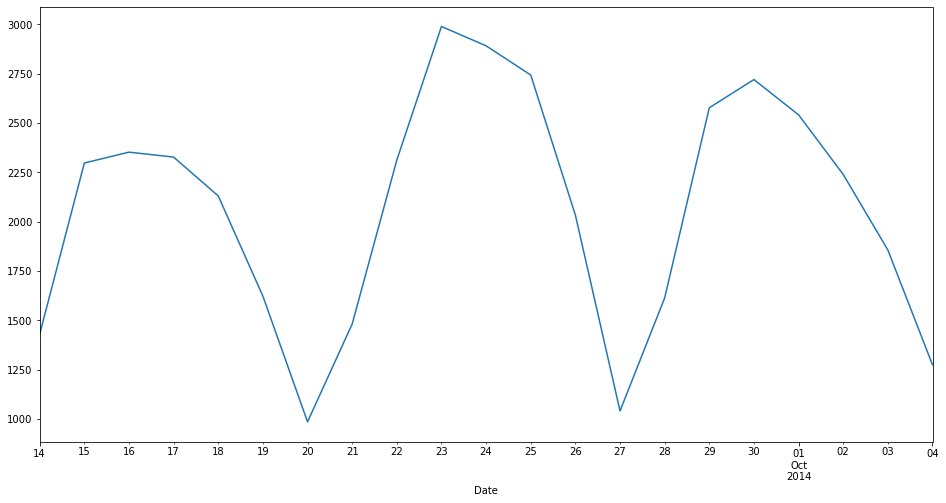

In [128]:
df['First.Time.Visits'].head(21).plot()

##### Time series appears to contain weekly seasonal component as well

C:\Users\Rudy\AppData\Local\Temp/ipykernel_15492/4102391038.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  resultSeasonal = seasonal_decompose(df['First.Time.Visits'], freq = 7)


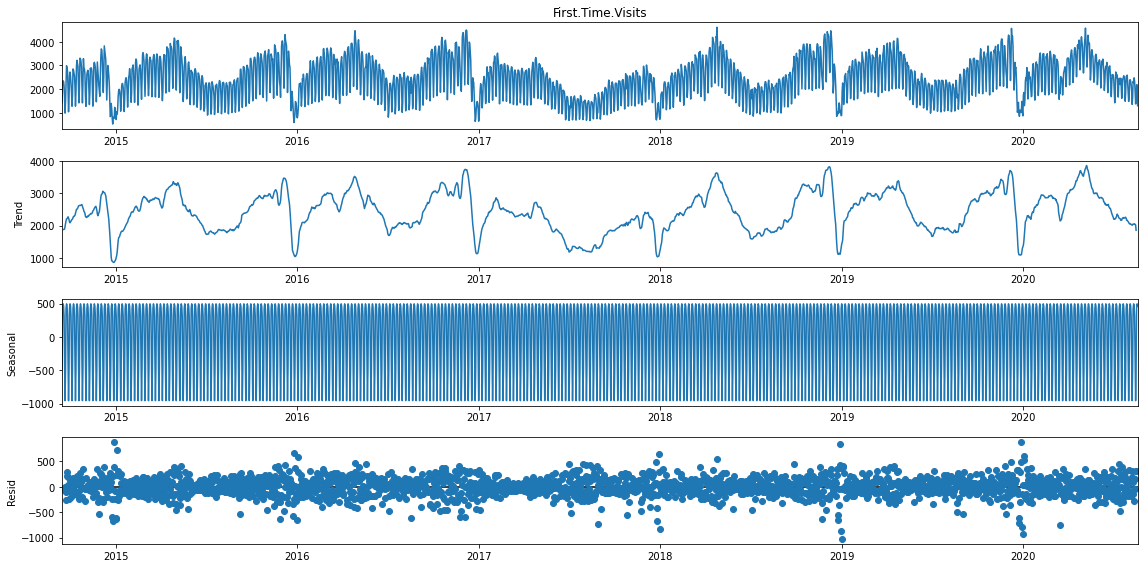

In [19]:
resultSeasonal = seasonal_decompose(df['First.Time.Visits'], freq = 7)
resultSeasonal.plot();

##### No idea how to take both into account, going to stick with resampled weekly data

### Checking stationarity

In [20]:
adfuller(df1) # null hypothesis: time series is non-stationary

(-5.361144359532205,
 4.08540684894091e-06,
 7,
 303,
 {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 4102.702546858949)

##### p-value is below 0.05, time series is stationary

### Checking correlations

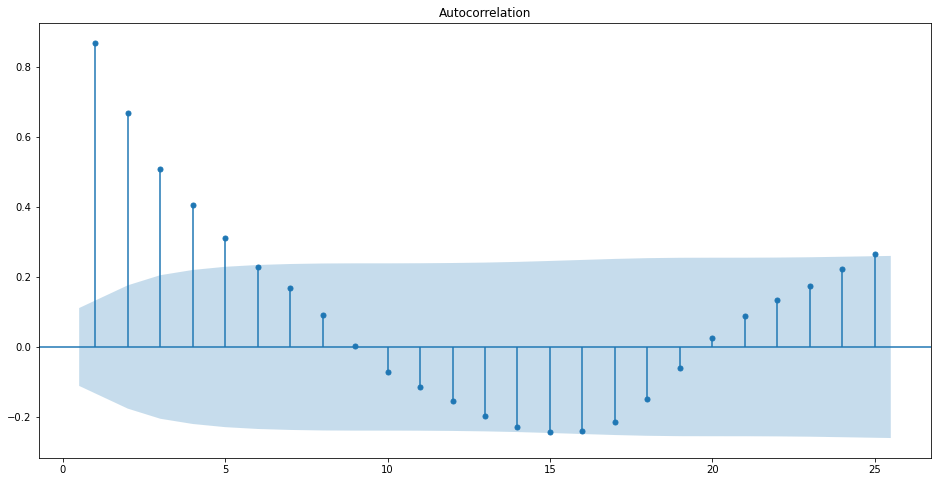

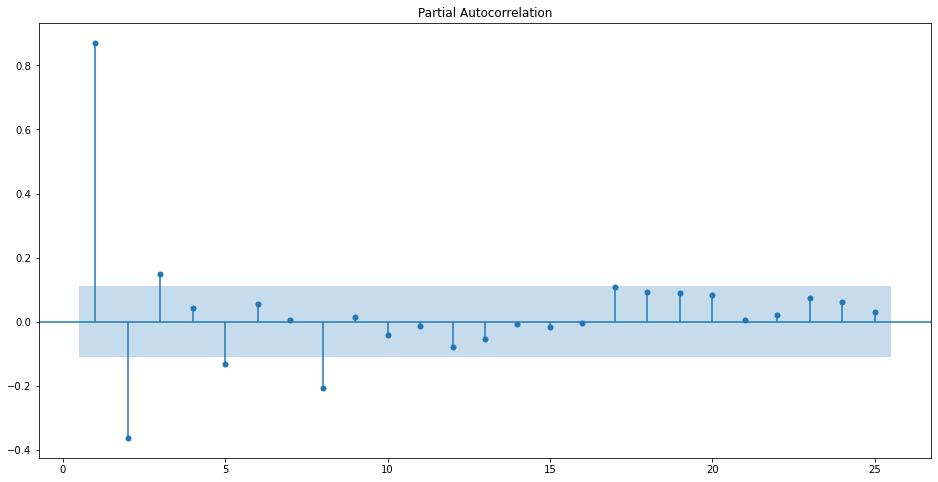

In [21]:
plot_acf(df1, zero = False);
plot_pacf(df1, zero = False);

##### Based on the plots, might be AR(3) model

### Starting out with auto-arima

In [13]:
auto_arima(df1, seasonal = True, m = 52, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4217.971, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4867.836, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4517.104, Time=1.33 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=5751.546, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=4277.397, Time=5.24 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=21.09 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=4208.140, Time=20.30 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=inf, Time=14.14 sec
 ARIMA(2,0,2)(2,0,2)[52] intercept   : AIC=inf, Time=23.91 sec
 ARIMA(1,0,2)(1,0,2)[52] intercept   : AIC=inf, Time=18.09 sec
 ARIMA(2,0,1)(1,0,2)[52] intercept   : AIC=4220.713, Time=17.23 sec
 ARIMA(3,0,2)(1,0,2)[52] intercept   : AIC=inf, Time=24.18 sec
 ARIMA(2,0,3)(1,0,2)[52] intercept   : AIC=4205

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  311
Model:             SARIMAX(1, 0, 4)x(1, 0, [1, 2], 52)   Log Likelihood               -2082.229
Date:                                 Fri, 13 May 2022   AIC                           4182.458
Time:                                         14:40:36   BIC                           4216.116
Sample:                                              0   HQIC                          4195.911
                                                 - 311                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9835      0.013     76.834      0.000       0.958       1.009
ma.L1          0.0256      0.037      0.684      0.494      -0.048       0.099
ma.L2         -0.1762      0.055     -3.204      0.001      -0.284      -0.068
ma.L3         -0.2057      0.055     -3.711      0.000      -0.314      -0.097
ma.L4          0.0913      0.064      1.436      0.151      -0.033       0.216
ar.S.L52       0.8940      0.025     36.114      0.000       0.845       0.943
ma.S.L52      -0.4022      0.073     -5.508      0.000      -0.545      -0.259
ma.S.L104      0.1289      0.070      1.844      0.065      -0.008       0.266
sigma2      3.104e+04   1897.797     16.358      0.000    2.73e+04    3.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               146.51
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train-test split

In [129]:
train_data = df1.iloc[:-4]
test_data = df1.iloc[-4:]

### Simple Exponential Smoothing

In [130]:
fitSES = SimpleExpSmoothing(train_data).fit()
fcastSES = fitSES.forecast(len(test_data)).rename('SES predict')

print(mean_squared_error(test_data, fcastSES))

47643.22530296515


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


### Holt's method

In [131]:
fitHolt1 = Holt(train_data, exponential = False).fit()
fcastHolt1 = fitHolt1.forecast(len(test_data)).rename("Holt's predict 1")

#Exponential
fitHolt2 = Holt(train_data, exponential = True).fit()
fcastHolt2 = fitHolt2.forecast(len(test_data)).rename("Holt's predict 2")

#Damped trend
fitHolt3 = Holt(train_data, damped_trend = True).fit()
fcastHolt3 = fitHolt3.forecast(len(test_data)).rename("Holt's predict 3")

#Exponential and damped
fitHolt4 = Holt(train_data, exponential = True, damped_trend = True).fit()
fcastHolt4 = fitHolt4.forecast(len(test_data)).rename("Holt's predict 4")

#finding out the best one based on MAPE
print(mean_squared_error(test_data, fcastHolt1))
print(mean_squared_error(test_data, fcastHolt2))
print(mean_squared_error(test_data, fcastHolt3))
print(mean_squared_error(test_data, fcastHolt4))

14523.943746607287
9322.927313399074
20236.872577775386
9618.050692259947


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


##### Just exponential gives the smallest error

### Holt-Winter's method

In [27]:
#multiplicative for both
fitHoltWinter1 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods = 52).fit()
fcastHoltWinter1 = fitHoltWinter1.forecast(len(test_data)).rename("Holt-Winter's predict 1")

#mul trend, add seasonal
fitHoltWinter2 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'add', seasonal_periods = 52).fit()
fcastHoltWinter2 = fitHoltWinter2.forecast(len(test_data)).rename("Holt-Winter's predict 2")

#add trend, mul seasonal
fitHoltWinter3 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'mul', seasonal_periods = 52).fit()
fcastHoltWinter3 = fitHoltWinter3.forecast(len(test_data)).rename("Holt-Winter's predict 3")

#both additive
fitHoltWinter4 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods = 52).fit()
fcastHoltWinter4 = fitHoltWinter4.forecast(len(test_data)).rename("Holt-Winter's predict 4")

print(mean_squared_error(test_data, fcastHoltWinter1))
print(mean_squared_error(test_data, fcastHoltWinter2))
print(mean_squared_error(test_data, fcastHoltWinter3))
print(mean_squared_error(test_data, fcastHoltWinter4))

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


74895.41428125708
66757.34376715153
34855.81043874995
55165.48420121865


##### Additive trend and multiplicative seasonal component gives lowest MAPE

### SARIMA

In [28]:
fitSARIMA = SARIMAX(train_data, order = (1, 0, 4), seasonal_order = (1, 0, 2, 52)).fit()
fitSARIMA.summary()

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                       First.Time.Visits   No. Observations:                  307
Model:             SARIMAX(1, 0, 4)x(1, 0, [1, 2], 52)   Log Likelihood               -2056.638
Date:                                 Tue, 07 Jun 2022   AIC                           4131.276
Time:                                         11:57:59   BIC                           4164.818
Sample:                                     09-14-2014   HQIC                          4144.689
                                          - 07-26-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9846      0.013     77.523      0.000       0.960       1.009
ma.L1          0.0246      0.038      0.653      0.514      -0.049       0.098
ma.L2         -0.1800      0.056     -3.241      0.001      -0.289      -0.071
ma.L3         -0.2150      0.056     -3.840      0.000      -0.325      -0.105
ma.L4          0.0903      0.064      1.413      0.158      -0.035       0.216
ar.S.L52       0.8940      0.025     35.736      0.000       0.845       0.943
ma.S.L52      -0.4089      0.074     -5.519      0.000      -0.554      -0.264
ma.S.L104      0.1319      0.071      1.868      0.062      -0.006       0.270
sigma2      3.121e+04   1917.299     16.281      0.000    2.75e+04     3.5e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               147.19
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start = len(train_data)
end = start + len(test_data) - 1
fcastSARIMA = fitSARIMA.predict(start = start, end = end, dynamic = False).rename('SARIMA')
print(mean_squared_error(test_data, fcastSARIMA))

48821.602296173136


### Prophet

In [30]:
data = train_data.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
data

,ds,y
0,2014-09-14,1430.000000
1,2014-09-21,1884.857143
2,2014-09-28,2231.571429
3,2014-10-05,2131.428571
4,2014-10-12,2300.142857
...,...,...
302,2020-06-28,2528.000000
303,2020-07-05,2193.285714
304,2020-07-12,2351.428571
305,2020-07-19,2162.142857


In [31]:
fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(len(test_data), freq = 'W')
fcastProphet = fitProphet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##### Going back to normal dataframe

In [32]:
prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-len(test_data):]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Date'
prophetForecast.columns = ['First.Time.Visits']
prophetForecast

,First.Time.Visits
Date,
2020-08-02,2182.351847
2020-08-09,2180.860046
2020-08-16,2215.797885
2020-08-23,2248.347887


In [33]:
mean_squared_error(test_data, prophetForecast['First.Time.Visits'])

45254.2927107737

### Plotting all of the best models

<AxesSubplot:xlabel='Date'>

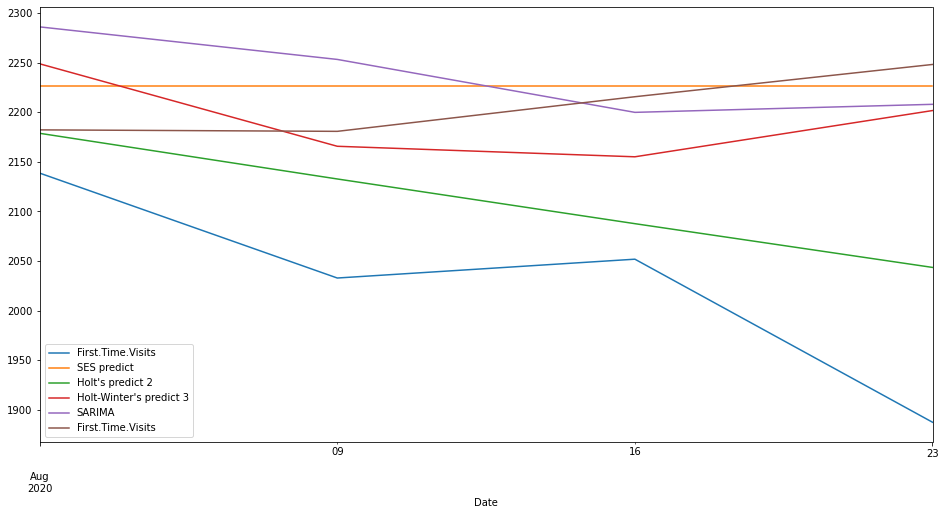

In [34]:
test_data.plot(legend = True)
fcastSES.plot(legend = True)
fcastHolt2.plot(legend = True)
fcastHoltWinter3.plot(legend = True)
fcastSARIMA.plot(legend = True)
prophetForecast['First.Time.Visits'].plot(legend = True)

##### Based on these results, Holt's method that looks just at the current trend is the best. This might be caused by ignoring the seasonal component or the fact that time series for this month keeps going down instead of staying at a level like for the past 5 years. Both of these facts shouldn't matter for the final forecast since we expect the time series to go up. Another possibility is that our residuals don't resemble white noise.

### Final forecast for 4 weeks into the future

In [132]:
#Simple exponential smoothing
fitSES = SimpleExpSmoothing(df1).fit()
fcastSES = fitSES.forecast(4).rename('SES predict')

#Holt's method
fitHolt = Holt(df1, exponential = True).fit()
fcastHolt = fitHolt.forecast(4).rename("Holt's predict")

#Holt-Winter's method
fitHoltWinter = ExponentialSmoothing(df1, trend = 'add', seasonal = 'mul', seasonal_periods = 52).fit()
fcastHoltWinter = fitHoltWinter.forecast(4).rename("Holt-Winter's predict")

#SARIMA
fitSARIMA = SARIMAX(df1, order = (1, 0, 4), seasonal_order = (1, 0, 2, 52)).fit()
start = len(df1)
end = start + 3
fcastSARIMA = fitSARIMA.predict(start = start, end = end, dynamic = False).rename('SARIMA')

#Prophet
data = df1.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(4, freq = 'W')
fcastProphet = fitProphet.predict(future)

#going back to normal dataframe from prophet
prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-4:]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Date'
prophetForecast.columns = ['First.Time.Visits']
prophetForecast

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_season

,First.Time.Visits
Date,
2020-08-30,2231.360981
2020-09-06,2316.522366
2020-09-13,2498.980460
2020-09-20,2738.991903


<AxesSubplot:xlabel='Date'>

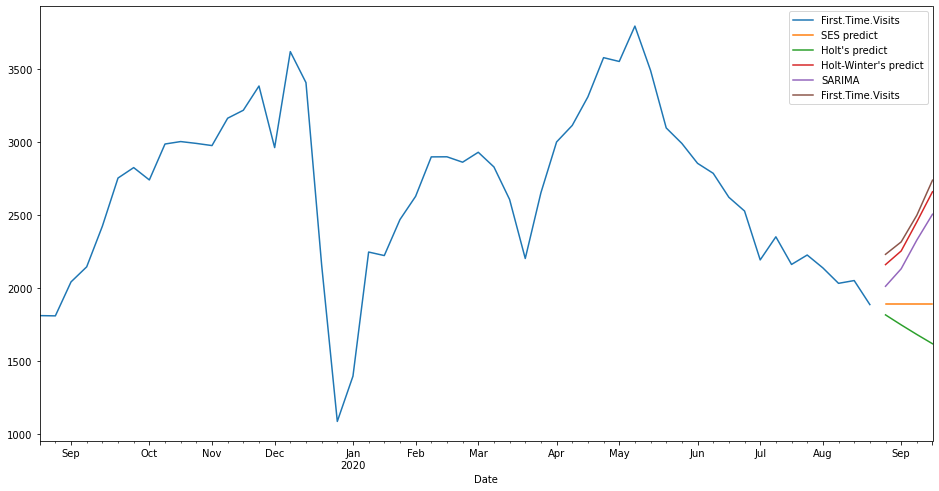

In [133]:
df1.tail(54).plot(legend = True)
fcastSES.plot(legend = True)
fcastHolt.plot(legend = True)
fcastHoltWinter.plot(legend = True)
fcastSARIMA.plot(legend = True)
prophetForecast['First.Time.Visits'].plot(legend = True)

##### We can see that SARIMA, Prophet and Holt-Winter's all follow the yearly trend and go upwards in september, with the main difference between them being their starting value and how fast they increase. SES stays level with the last data point, while Holt's method follows the last observed trend and keeps decreasing. We can safely assume that if the pattern observed in the last 5 years stays the same both of these methods will give really bad forecasts.

### Testing out differencing to remove the yearly seasonal compontent.

In [134]:
df1 = df['First.Time.Visits'].diff(365).dropna()
df1

Date
2015-09-14    1524.0
2015-09-15     647.0
2015-09-16     550.0
2015-09-17     409.0
2015-09-18    -106.0
               ...  
2020-08-15    -290.0
2020-08-16     612.0
2020-08-17     704.0
2020-08-18    -187.0
2020-08-19    -996.0
Freq: D, Name: First.Time.Visits, Length: 1802, dtype: float64

C:\Users\Rudy\AppData\Local\Temp/ipykernel_15492/4060646942.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  resultSeasonal = seasonal_decompose(df1, freq = 7)


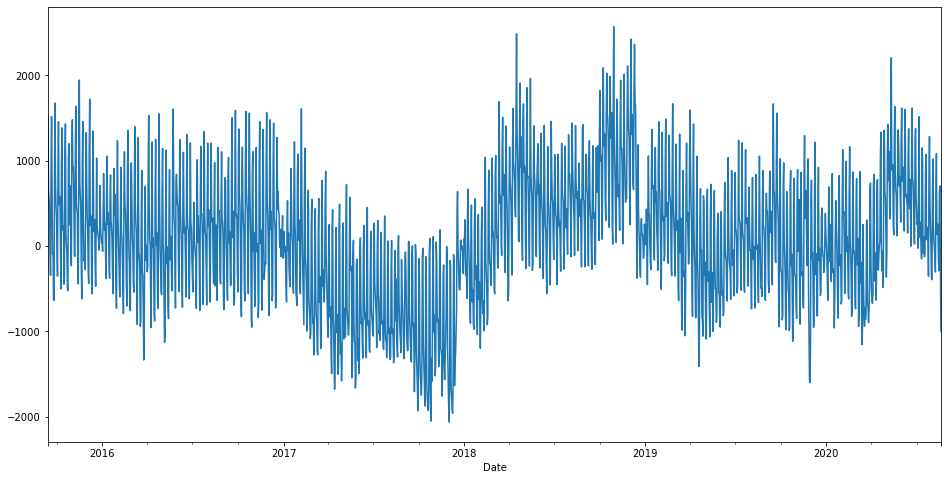

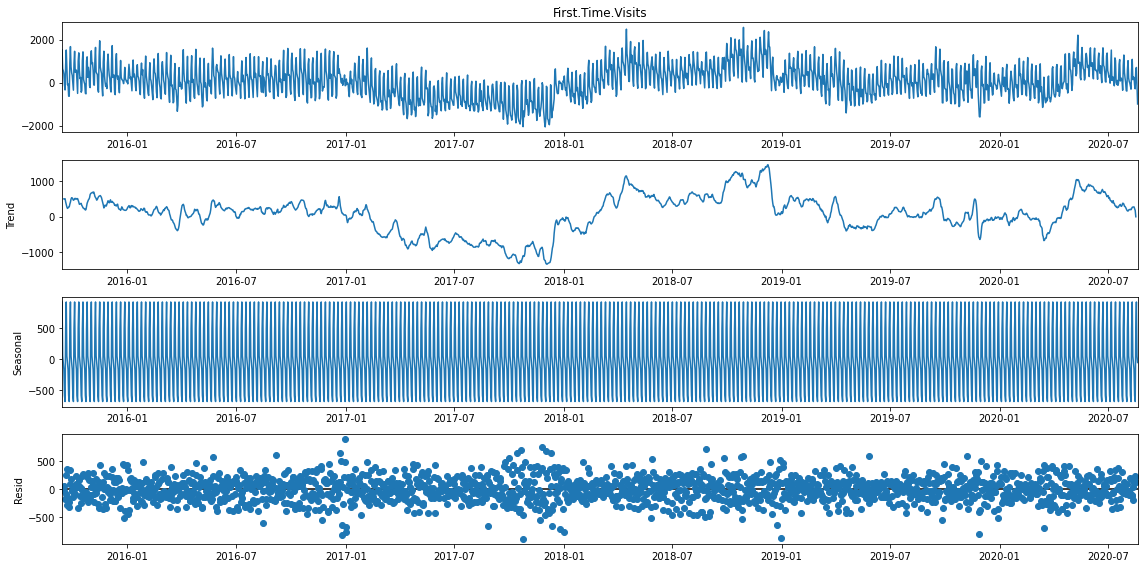

In [36]:
plt.rc("figure", figsize = (16, 8))
df1.plot()
resultSeasonal = seasonal_decompose(df1, freq = 7)
resultSeasonal.plot();

### Checking stationarity

In [29]:
adfuller(df1) # null hypothesis: time series is non-stationary

(-2.8736866944947317,
 0.048494556954374046,
 22,
 1779,
 {'1%': -3.434031147125674,
  '5%': -2.863166021720215,
  '10%': -2.5676356430449427},
 24463.68985856995)

##### p-value is below 0.05, time series is stationary

### Checking correlations

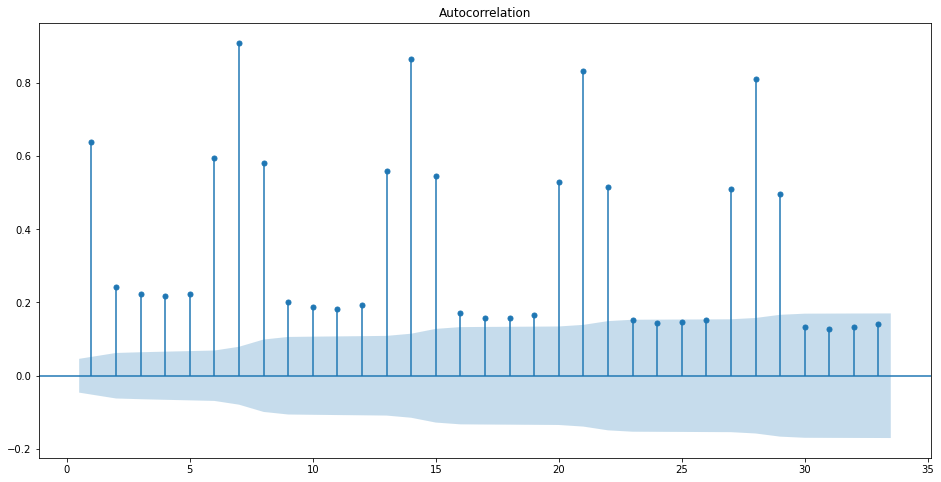

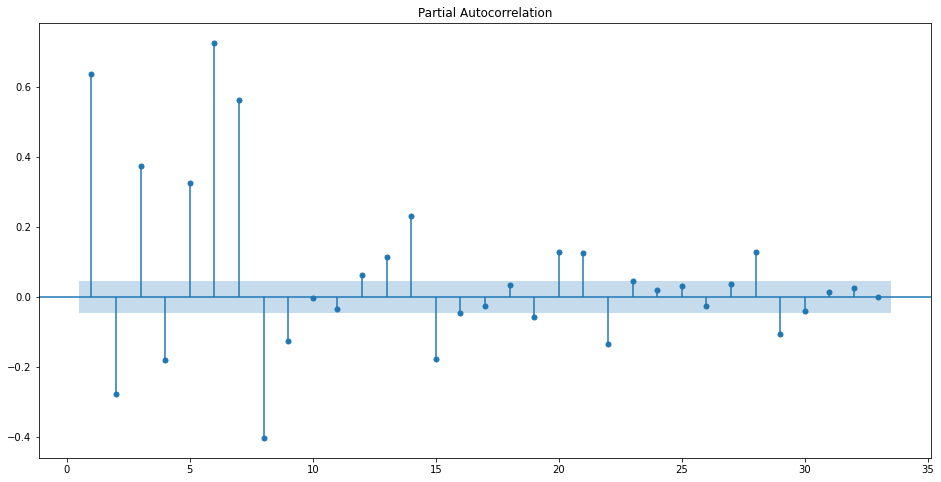

In [30]:
plot_acf(df1, zero = False);
plot_pacf(df1, zero = False);

##### We have a lot of correlations.

### Starting out with auto-arima

In [31]:
auto_arima(df1, seasonal = True, m = 7, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=28475.578, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=25530.533, Time=1.63 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=27100.502, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=28473.587, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=28473.196, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=25063.454, Time=1.77 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=27237.170, Time=0.55 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=25012.985, Time=3.77 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=26619.572, Time=1.06 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=inf, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1802
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -12383.187
Date:                           Fri, 13 May 2022   AIC                          24780.373
Time:                                   14:43:30   BIC                          24818.846
Sample:                                        0   HQIC                         24794.574
                                          - 1802                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.026      0.061      0.952      -0.050       0.053
ma.L1         -0.3734      0.018    -20.547      0.000      -0.409      -0.338
ma.L2         -0.3100      0.019    -16.103      0.000      -0.348      -0.272
ar.S.L7        1.0000   3.84e-06   2.61e+05      0.000       1.000       1.000
ma.S.L7       -0.7406      0.020    -37.316      0.000      -0.780      -0.702
ma.S.L14      -0.1492      0.019     -7.866      0.000      -0.186      -0.112
sigma2      5.189e+04   6.72e-08   7.73e+11      0.000    5.19e+04    5.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):               284.38
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.28
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+25. Standard errors may be unstable.
"""

### Train-test split

In [135]:
train_data = df1.iloc[:-30]
test_data = df1.iloc[-30:]

### Simple Exponential Smoothing

In [136]:
fitSES2 = SimpleExpSmoothing(train_data).fit()
fcastSES2 = fitSES2.forecast(len(test_data)).rename('SES predict')
print(mean_squared_error(test_data, fcastSES2))

319489.6193081493


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


### Holt's method

In [137]:
fitHolt1_2 = Holt(train_data, exponential = False).fit()
fcastHolt1_2 = fitHolt1_2.forecast(len(test_data)).rename("Holt's predict 1")

#Damped trend
fitHolt2_2 = Holt(train_data, damped_trend = True).fit()
fcastHolt2_2 = fitHolt2_2.forecast(len(test_data)).rename("Holt's predict 2")

#finding out the best one based on MAPE
print(mean_squared_error(test_data, fcastHolt1_2))
print(mean_squared_error(test_data, fcastHolt2_2))

1476497.2286083808
1413897.0764919824


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


##### Errores for both SES and Holt are too big to even consider them for final forecast.

### Holt-Winter's method

In [138]:
#both additive
fitHoltWinter2 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods = 7).fit()
fcastHoltWinter2 = fitHoltWinter2.forecast(len(test_data)).rename("Holt-Winter's predict")

print(mean_squared_error(test_data, fcastHoltWinter2))

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


62851.01099061466


##### Still really big MAPE.

### SARIMA

In [139]:
fitSARIMA2 = SARIMAX(train_data, order = (0, 1, 2), seasonal_order = (1, 0, 2, 7)).fit()
fitSARIMA2.summary()

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 First.Time.Visits   No. Observations:                 1772
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -12177.213
Date:                           Tue, 07 Jun 2022   AIC                          24366.426
Time:                                   12:34:15   BIC                          24399.302
Sample:                               09-14-2015   HQIC                         24378.571
                                    - 07-20-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3757      0.019    -20.047      0.000      -0.412      -0.339
ma.L2         -0.3175      0.020    -15.969      0.000      -0.356      -0.279
ar.S.L7        1.0000   2.35e-06   4.26e+05      0.000       1.000       1.000
ma.S.L7       -0.7387      0.020    -36.261      0.000      -0.779      -0.699
ma.S.L14      -0.1743      0.020     -8.900      0.000      -0.213      -0.136
sigma2      5.331e+04   6.27e-08    8.5e+11      0.000    5.33e+04    5.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):               229.71
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.26
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+26. Standard errors may be unstable.
"""

In [140]:
start = len(train_data)
end = start + len(test_data) - 1
fcastSARIMA2 = fitSARIMA2.predict(start = start, end = end, dynamic = False).rename('SARIMA')
print(mean_squared_error(test_data, fcastSARIMA2))

72144.44784342105


### Prophet

In [141]:
data = train_data.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
data

,ds,y
0,2015-09-14,1524.0
1,2015-09-15,647.0
2,2015-09-16,550.0
3,2015-09-17,409.0
4,2015-09-18,-106.0
...,...,...
1767,2020-07-16,103.0
1768,2020-07-17,-127.0
1769,2020-07-18,-35.0
1770,2020-07-19,859.0


In [142]:
fitProphet = Prophet(weekly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(len(test_data))
fcastProphet = fitProphet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##### Going back to normal dataframe

In [143]:
prophetForecast2 = fcastProphet[['ds', 'yhat']].iloc[-len(test_data):]
prophetForecast2.set_index('ds', inplace = True)
prophetForecast2.index.name = 'Date'
prophetForecast2.columns = ['Prophet']
prophetForecast2.index.freq = 'D'
prophetForecast2

,Prophet
Date,
2020-07-21,419.519843
2020-07-22,315.548031
2020-07-23,208.350486
2020-07-24,-215.755736
2020-07-25,-310.931253
2020-07-26,862.572809
2020-07-27,1288.287455
2020-07-28,422.109057
2020-07-29,315.678952


In [144]:
mean_squared_error(test_data, prophetForecast2['Prophet'])

107419.25811997292

### Plotting all of the best models

<AxesSubplot:xlabel='Date'>

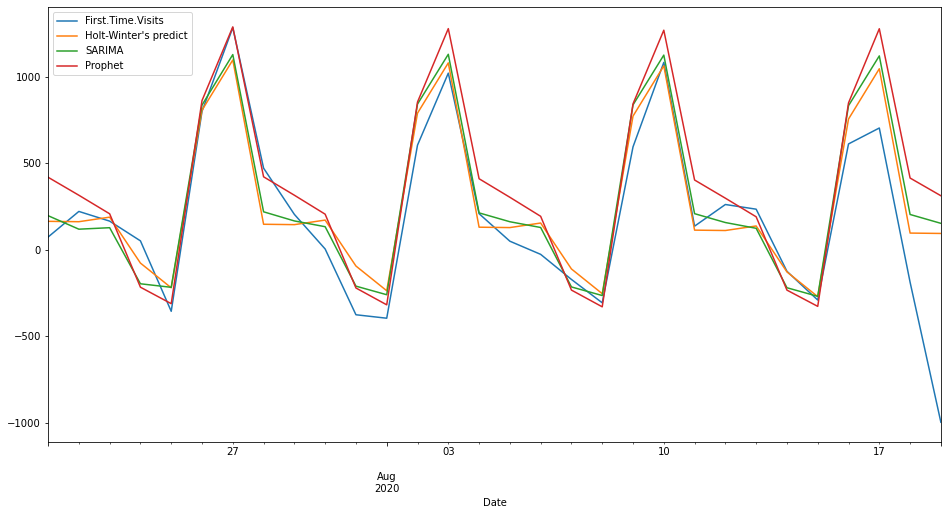

In [145]:
test_data.plot(legend = True)
fcastHoltWinter2.plot(legend = True)
fcastSARIMA2.plot(legend = True)
prophetForecast2['Prophet'].plot(legend = True)

In [146]:
#HoltWinters
beforeDiff = np.array([])
for i in range(0, len(fcastHoltWinter2)):
    beforeDiff = np.append(beforeDiff, df['First.Time.Visits'][-395 + i] + fcastHoltWinter2[i])

beforeDiff = pd.DataFrame(beforeDiff, columns = ['HoltWinter'])
index = pd.date_range(start = "2020-07-21", end = "2020-08-19", freq = "D")
beforeDiff = beforeDiff.set_index(index)

#SARIMA
SARIMADiff = np.array([])
for i in range(0, len(fcastSARIMA2)):
    SARIMADiff = np.append(SARIMADiff, df['First.Time.Visits'][-395 + i] + fcastSARIMA2[i])

beforeDiff['SARIMA'] = SARIMADiff


#Prophet
ProphetDiff = np.array([])
for i in range(0, len(prophetForecast2['Prophet'])):
    ProphetDiff = np.append(ProphetDiff, df['First.Time.Visits'][-395 + i] + prophetForecast2['Prophet'][i])

beforeDiff['Prophet'] = ProphetDiff

beforeDiff

,HoltWinter,SARIMA,Prophet
2020-07-21,2540.841074,2573.490646,2795.519843
2020-07-22,2506.649402,2463.396368,2659.548031
2020-07-23,2547.957088,2487.008201,2567.350486
2020-07-24,2133.565378,2013.960373,1994.244264
2020-07-25,1622.756515,1625.591080,1531.068747
2020-07-26,1875.795510,1905.665078,1931.572809
2020-07-27,2336.242126,2367.344821,2527.287455
2020-07-28,2200.868692,2272.866010,2475.109057
2020-07-29,2531.677019,2553.088454,2701.678952
2020-07-30,2431.984705,2393.785815,2466.068022


<AxesSubplot:xlabel='Date'>

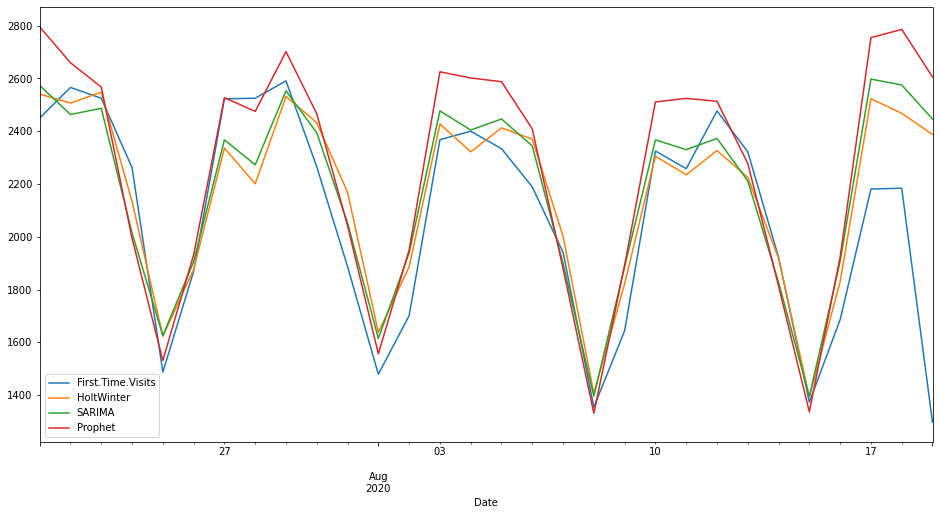

In [147]:
df['First.Time.Visits'].iloc[-30:].plot(legend = True)
beforeDiff['HoltWinter'].plot(legend = True)
beforeDiff['SARIMA'].plot(legend = True)
beforeDiff['Prophet'].plot(legend = True)

##### Even though the MAPE were really big, the forecasts don't look too bad. Have to invert differencing to really make sure but will leave that for after final forecast.

### Final forecast for 30 days into the future

In [148]:
#Holt-Winter's method
fitHoltWinter2 = ExponentialSmoothing(df1, trend = 'add', seasonal = 'add', seasonal_periods = 7).fit()
fcastHoltWinter2 = fitHoltWinter2.forecast(30).rename("Holt-Winter's predict")

#SARIMA
fitSARIMA2 = SARIMAX(df1, order = (0, 1, 2), seasonal_order = (1, 0, 2, 7)).fit()
start = len(df1)
end = start + 29
fcastSARIMA2 = fitSARIMA2.predict(start = start, end = end, dynamic = False).rename('SARIMA')

#Prophet
data = df1.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
fitProphet = Prophet(weekly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(30)
fcastProphet = fitProphet.predict(future)

#going back to normal dataframe from prophet
prophetForecast2 = fcastProphet[['ds', 'yhat']].iloc[-30:]
prophetForecast2.set_index('ds', inplace = True)
prophetForecast2.index.name = 'Date'
prophetForecast2.columns = ['Prophet']
prophetForecast2.index.freq = 'D'

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='Date'>

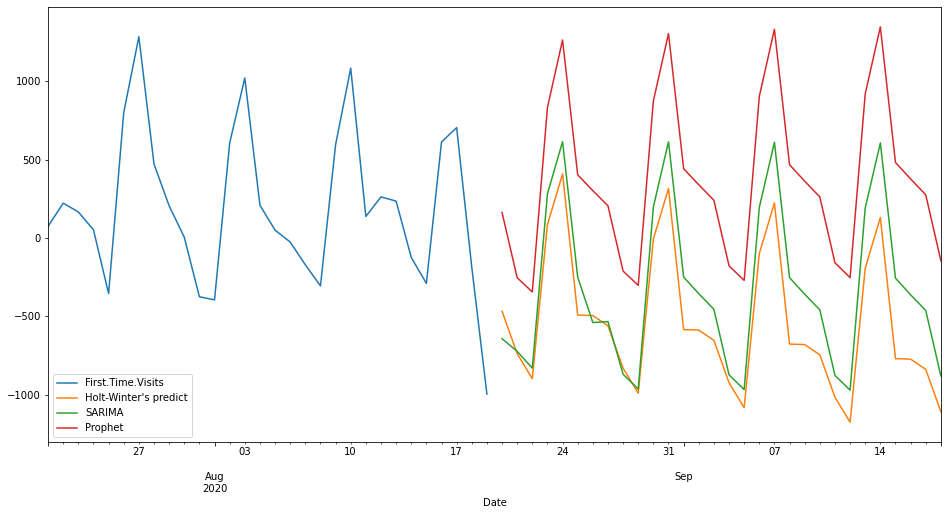

In [149]:
df1.tail(30).plot(legend = True)
fcastHoltWinter2.plot(legend = True)
fcastSARIMA2.plot(legend = True)
prophetForecast2['Prophet'].plot(legend = True)

### Inverting differencing

In [150]:
#HoltWinters
beforeDiff = np.array([])
for i in range(0, len(fcastHoltWinter2)):
    beforeDiff = np.append(beforeDiff, df['First.Time.Visits'][-365 + i] + fcastHoltWinter2[i])

beforeDiff = pd.DataFrame(beforeDiff, columns = ['HoltWinter'])
index = pd.date_range(start = "2020-08-20", end = "2020-09-18", freq = "D")
beforeDiff = beforeDiff.set_index(index)

#SARIMA
SARIMADiff = np.array([])
for i in range(0, len(fcastSARIMA2)):
    SARIMADiff = np.append(SARIMADiff, df['First.Time.Visits'][-365 + i] + fcastSARIMA2[i])

beforeDiff['SARIMA'] = SARIMADiff


#Prophet
ProphetDiff = np.array([])
for i in range(0, len(prophetForecast2['Prophet'])):
    ProphetDiff = np.append(ProphetDiff, df['First.Time.Visits'][-365 + i] + prophetForecast2['Prophet'][i])

beforeDiff['Prophet'] = ProphetDiff

beforeDiff

,HoltWinter,SARIMA,Prophet
2020-08-20,1495.249523,1320.301014,2125.760992
2020-08-21,888.999366,903.389958,1373.221874
2020-08-22,871.272051,938.573573,1424.209728
2020-08-23,1236.590154,1432.074428,1982.931276
2020-08-24,1905.389359,2111.379699,2760.282713
2020-08-25,1765.246271,2006.738279,2659.679709
2020-08-26,2126.799365,2082.187813,2923.817358
2020-08-27,2062.587455,2089.593985,2827.866301
2020-08-28,1646.337298,1607.284874,2265.735790
2020-08-29,736.609984,763.187282,1424.619998


<AxesSubplot:>

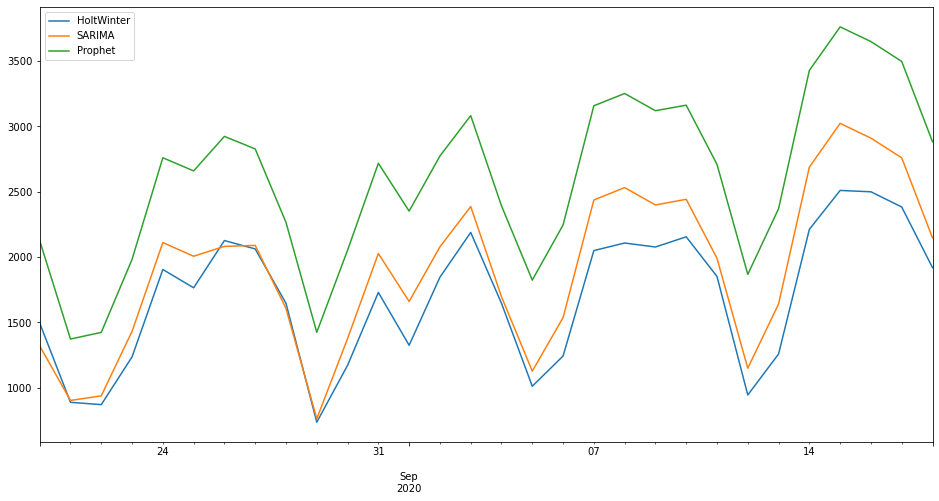

In [151]:
beforeDiff['HoltWinter'].plot(legend = True)
beforeDiff['SARIMA'].plot(legend = True)
beforeDiff['Prophet'].plot(legend = True)

##### Because of the weekly differences it's hard to notice changes but we can see that there is a clear upwards trend. The downside is that the differences between days might be too big compared to the previously analysed models. Looking at forecasts, Prophet seems to be doing the best with the smallest overall changes between highs and lows while still keeping up with expected increase in traffic.

### Testing out Prophet with both yearly and weekly seasonality

In [155]:
data = df.iloc[:-30].reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
fitProphet = Prophet(weekly_seasonality = True, yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(30)
fcastProphet = fitProphet.predict(future)

#going back to normal dataframe from prophet
prophetForecast3 = fcastProphet[['ds', 'yhat']].iloc[-30:]
prophetForecast3.set_index('ds', inplace = True)
prophetForecast3.index.name = 'Date'
prophetForecast3.columns = ['Prophet']
prophetForecast3.index.freq = 'D'

print(mean_squared_error(df['First.Time.Visits'][-30:], prophetForecast3['Prophet']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


122877.31120579691


In [153]:
data = df.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
fitProphet = Prophet(weekly_seasonality = True, yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(30)
fcastProphet = fitProphet.predict(future)

#going back to normal dataframe from prophet
prophetForecast3 = fcastProphet[['ds', 'yhat']].iloc[-30:]
prophetForecast3.set_index('ds', inplace = True)
prophetForecast3.index.name = 'Date'
prophetForecast3.columns = ['Prophet']
prophetForecast3.index.freq = 'D'

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='Date'>

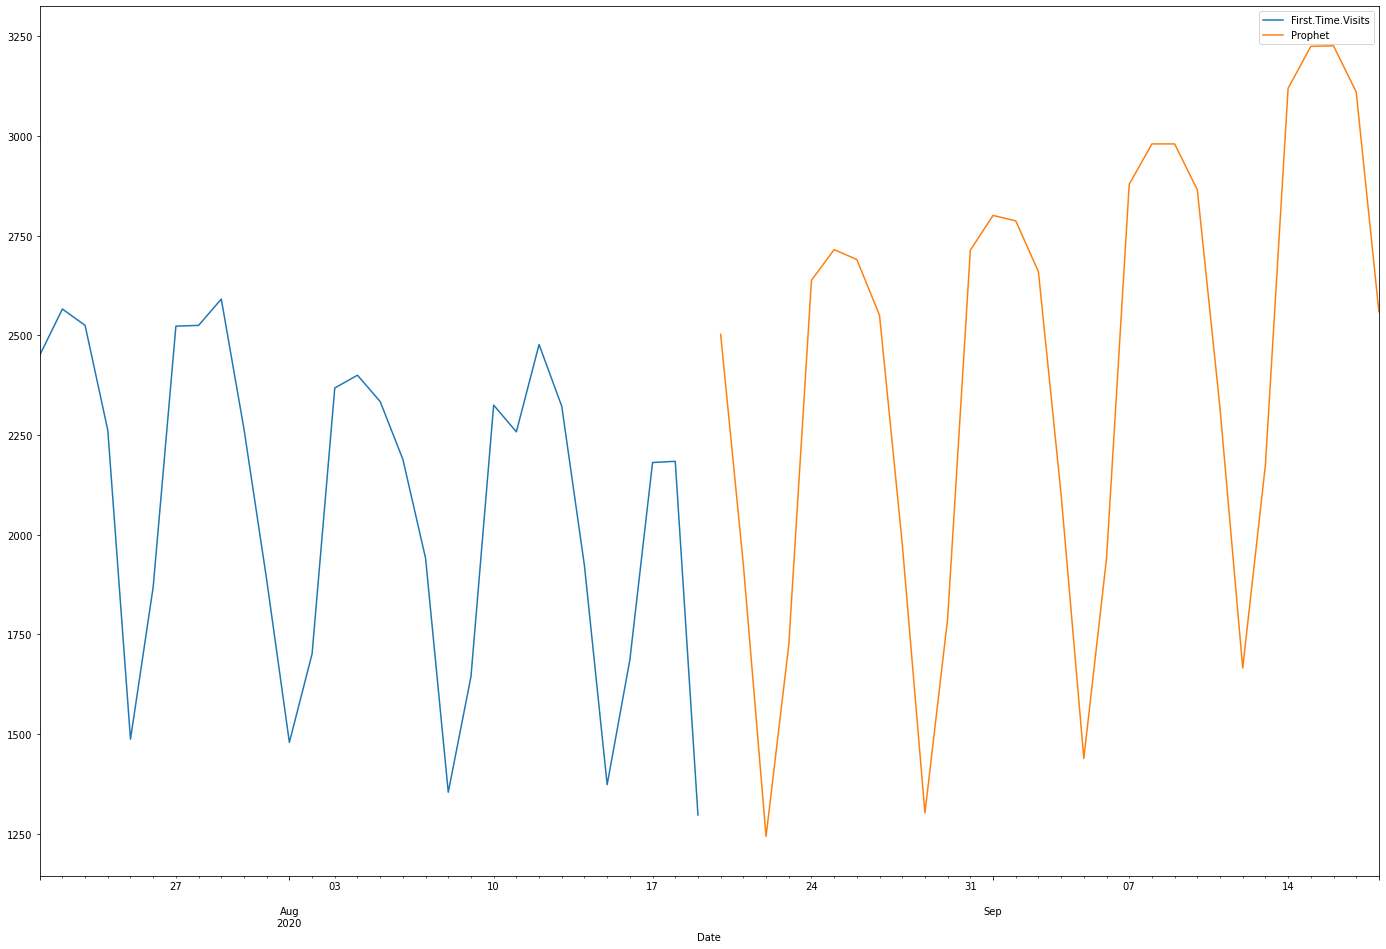

In [121]:
df['First.Time.Visits'].tail(30).plot(legend = True)
prophetForecast3['Prophet'].plot(legend = True)

##### Prophet that takes into account both weekly and seasonal trends gives the best possible results. There are no huge jumps outside of our expectations for the weekly changes while keeping up with the yearly trend.

### Comparing all of the obtained results with final Prophet model as baseline for best fit.

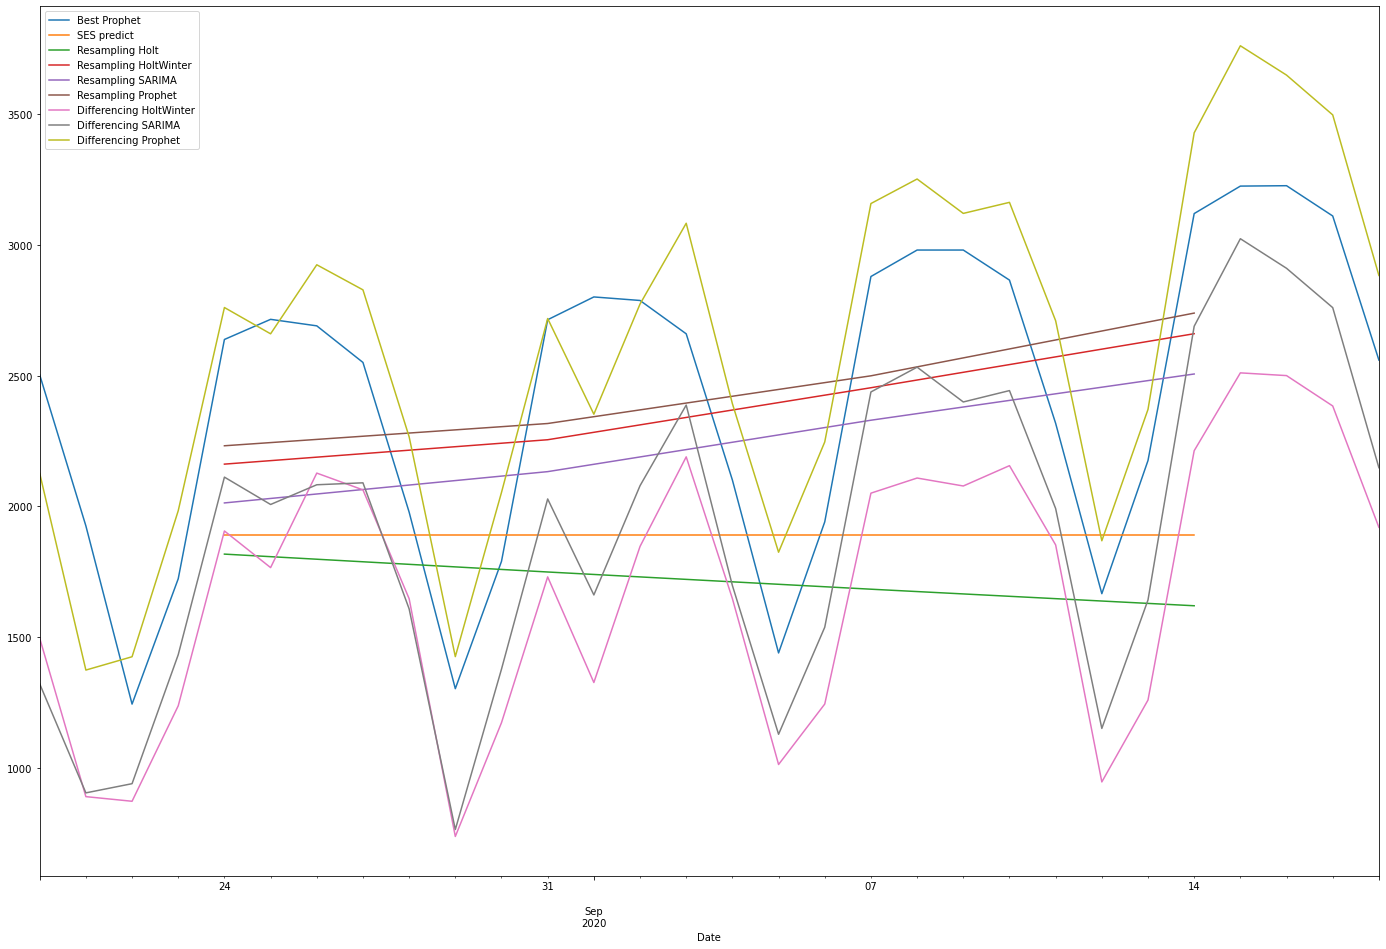

In [154]:
plt.rc("figure", figsize = (24, 16))

#best prophet
prophetForecast3['Prophet'].plot(label = "Best Prophet")

#weekly resampling
fcastSES.plot()
fcastHolt.plot(label = "Resampling Holt")
fcastHoltWinter.plot(label = "Resampling HoltWinter")
fcastSARIMA.plot(label = "Resampling SARIMA")
prophetForecast['First.Time.Visits'].plot(label = "Resampling Prophet")

#yearly differencing
beforeDiff['HoltWinter'].plot(label = "Differencing HoltWinter")
beforeDiff['SARIMA'].plot(label = "Differencing SARIMA")
beforeDiff['Prophet'].plot(label = "Differencing Prophet")

plt.legend()

##### As I though previously, the model where I used differenced time series leads to too big changes on a weekly basis. On the other hand, not taking them into considerations doesn't show us the full picture, giving just the weekly average. Obviously the best model is the last Prophet since it's using all avaible trends in the dataset.

### Using original time series for forecasts with weekly seasonality

In [156]:
df1 = df['First.Time.Visits']
df1

Date
2014-09-14    1430
2014-09-15    2297
2014-09-16    2352
2014-09-17    2327
2014-09-18    2130
              ... 
2020-08-15    1373
2020-08-16    1686
2020-08-17    2181
2020-08-18    2184
2020-08-19    1297
Freq: D, Name: First.Time.Visits, Length: 2167, dtype: int32

C:\Users\Rudy\AppData\Local\Temp/ipykernel_12076/3189490167.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  resultSeasonal = seasonal_decompose(df1, freq = 7)


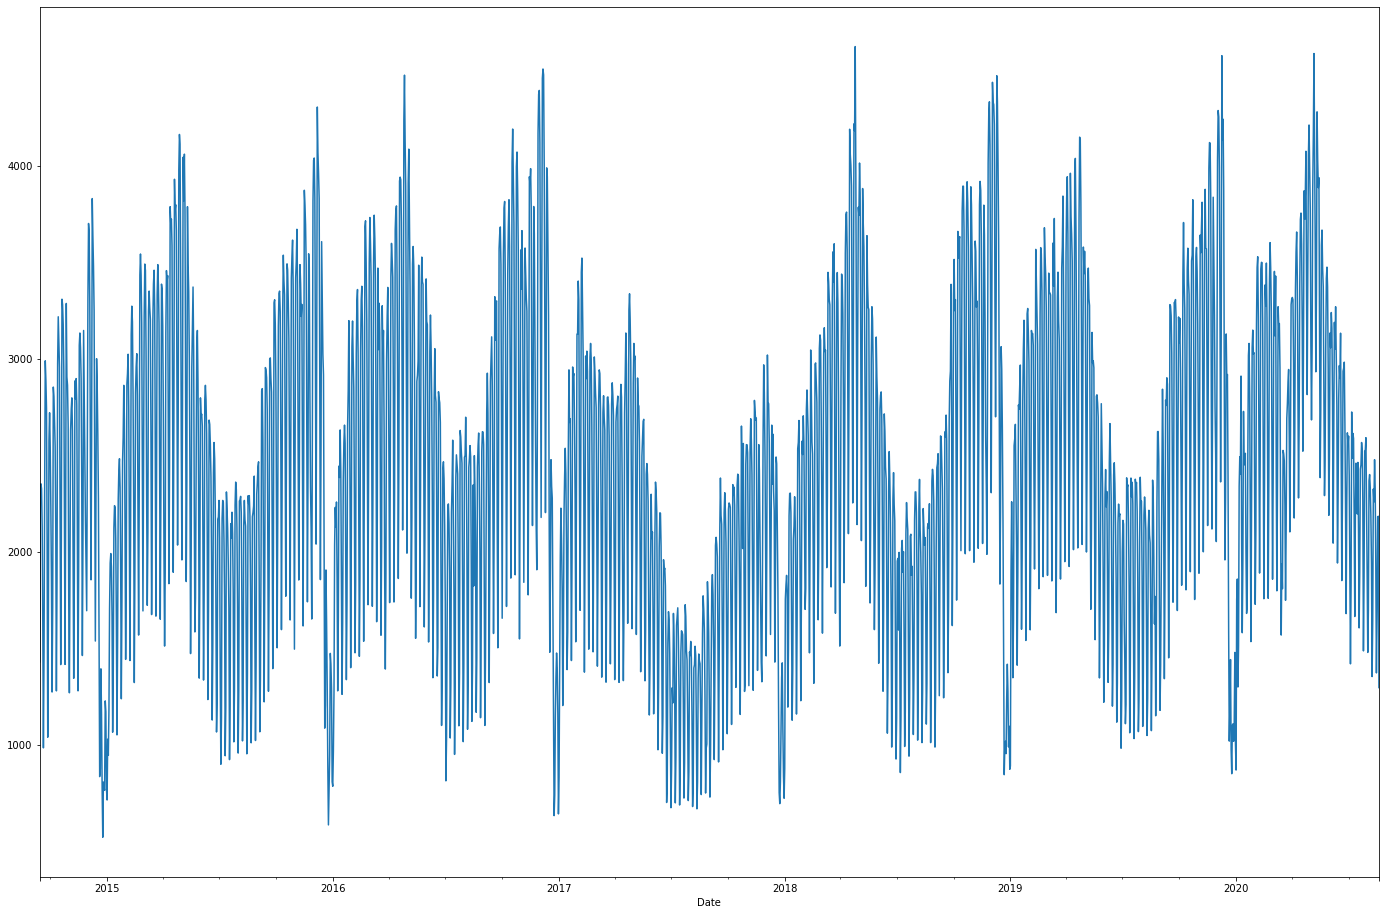

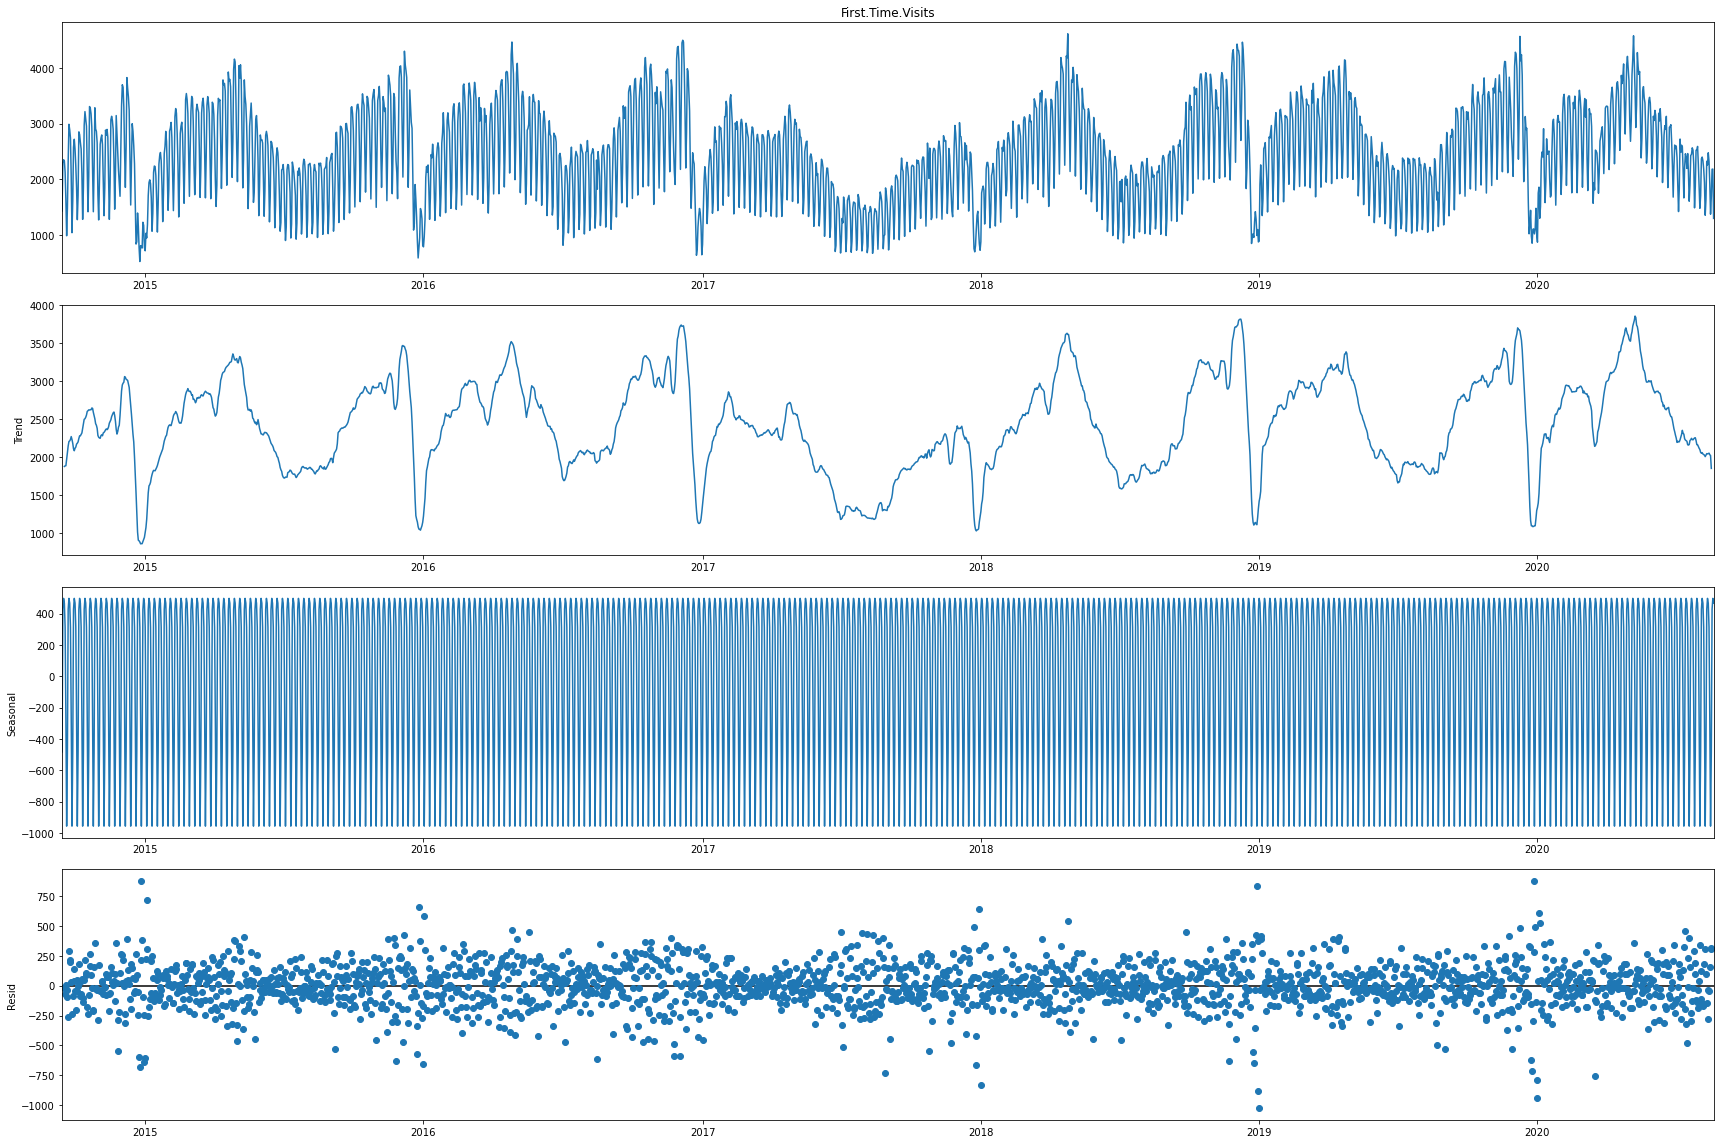

In [51]:
df1.plot()
resultSeasonal = seasonal_decompose(df1, freq = 7)
resultSeasonal.plot();

### Starting out with auto-arima

In [52]:
auto_arima(df1, seasonal = True, m = 7, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=29239.214, Time=3.51 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33582.394, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29798.887, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=31761.991, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33580.394, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=30650.623, Time=3.11 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=11.13 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=11.17 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=31477.422, Time=1.01 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=30574.240, Time=6.83 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=12.17 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=29184.157, Time=3.41 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=3122

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2167
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -14584.949
Date:                             Fri, 13 May 2022   AIC                          29181.898
Time:                                     14:46:31   BIC                          29215.982
Sample:                                          0   HQIC                         29194.362
                                            - 2167                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3412      0.060      5.684      0.000       0.224       0.459
ma.L1         -0.3571      0.062     -5.789      0.000      -0.478      -0.236
ma.L2         -0.2031      0.020    -10.095      0.000      -0.243      -0.164
ar.S.L7        1.0000   3.67e-05   2.72e+04      0.000       1.000       1.000
ma.S.L7       -0.8162      0.012    -68.249      0.000      -0.840      -0.793
sigma2      4.062e+04    848.870     47.850      0.000     3.9e+04    4.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               647.34
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train-test split

In [157]:
train_data = df1.iloc[:-30]
test_data = df1.iloc[-30:]

### Simple Exponential Smoothing

In [158]:
fitSES3 = SimpleExpSmoothing(train_data).fit()
fcastSES3 = fitSES3.forecast(len(test_data)).rename('SES predict')
print(mean_squared_error(test_data, fcastSES3))

281332.8886484791


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


### Holt's method

In [159]:
fitHolt1_3 = Holt(train_data, exponential = False).fit()
fcastHolt1_3 = fitHolt1_3.forecast(len(test_data)).rename("Holt's predict 1")

#Exponential
fitHolt2_3 = Holt(train_data, exponential = True).fit()
fcastHolt2_3 = fitHolt2_3.forecast(len(test_data)).rename("Holt's predict 2")

#Damped trend
fitHolt3_3 = Holt(train_data, damped_trend = True).fit()
fcastHolt3_3 = fitHolt3_3.forecast(len(test_data)).rename("Holt's predict 3")

#Exponential and damped
fitHolt4_3 = Holt(train_data, exponential = True, damped_trend = True).fit()
fcastHolt4_3 = fitHolt4_3.forecast(len(test_data)).rename("Holt's predict 4")

#finding out the best one based on MAPE
print(mean_squared_error(test_data, fcastHolt1_3))
print(mean_squared_error(test_data, fcastHolt2_3))
print(mean_squared_error(test_data, fcastHolt3_3))
print(mean_squared_error(test_data, fcastHolt4_3))

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: Convergen

223441.73243734692
2158906.749244472
254429.5856467532
932151.9222682703


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


##### Errores for both SES and Holt are too big to even consider them for final forecast.

### Holt-Winter's method

In [160]:
#multiplicative for both
fitHoltWinter1_3 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods = 7).fit()
fcastHoltWinter1_3 = fitHoltWinter1_3.forecast(len(test_data)).rename("Holt-Winter's predict 1")

#mul trend, add seasonal
fitHoltWinter2_3 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'add', seasonal_periods = 7).fit()
fcastHoltWinter2_3 = fitHoltWinter2_3.forecast(len(test_data)).rename("Holt-Winter's predict 2")

#add trend, mul seasonal
fitHoltWinter3_3 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'mul', seasonal_periods = 7).fit()
fcastHoltWinter3_3 = fitHoltWinter3_3.forecast(len(test_data)).rename("Holt-Winter's predict 3")

#both additive
fitHoltWinter4_3 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods = 7).fit()
fcastHoltWinter4_3 = fitHoltWinter4_3.forecast(len(test_data)).rename("Holt-Winter's predict 4")

print(mean_squared_error(test_data, fcastHoltWinter1_3))
print(mean_squared_error(test_data, fcastHoltWinter2_3))
print(mean_squared_error(test_data, fcastHoltWinter3_3))
print(mean_squared_error(test_data, fcastHoltWinter4_3))

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


61095.23737606506
106214.46559365319
38590.87632363946
199993.96840809617


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


##### Still really big MAPE.

### SARIMA

In [161]:
fitSARIMA3 = SARIMAX(train_data, order = (1, 1, 2), seasonal_order = (1, 0, 1, 7)).fit()
fitSARIMA3.summary()

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   First.Time.Visits   No. Observations:                 2137
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -14382.328
Date:                             Tue, 07 Jun 2022   AIC                          28776.657
Time:                                     12:37:51   BIC                          28810.657
Sample:                                 09-14-2014   HQIC                         28789.099
                                      - 07-20-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3416      0.060      5.684      0.000       0.224       0.459
ma.L1         -0.3561      0.062     -5.765      0.000      -0.477      -0.235
ma.L2         -0.2039      0.020    -10.094      0.000      -0.243      -0.164
ar.S.L7        1.0000   3.58e-05    2.8e+04      0.000       1.000       1.000
ma.S.L7       -0.8140      0.012    -67.708      0.000      -0.838      -0.790
sigma2      4.058e+04    873.729     46.441      0.000    3.89e+04    4.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               564.51
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.11
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
start = len(train_data)
end = start + len(test_data) - 1
fcastSARIMA3 = fitSARIMA3.predict(start = start, end = end, dynamic = False).rename('SARIMA')
print(mean_squared_error(test_data, fcastSARIMA3))

45197.286152670466


### Prophet

In [163]:
data = train_data.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
data

,ds,y
0,2014-09-14,1430
1,2014-09-15,2297
2,2014-09-16,2352
3,2014-09-17,2327
4,2014-09-18,2130
...,...,...
2132,2020-07-16,2463
2133,2020-07-17,2122
2134,2020-07-18,1606
2135,2020-07-19,1892


In [164]:
fitProphet = Prophet(weekly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(len(test_data))
fcastProphet = fitProphet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##### Going back to normal dataframe

In [165]:
prophetForecast3 = fcastProphet[['ds', 'yhat']].iloc[-len(test_data):]
prophetForecast3.set_index('ds', inplace = True)
prophetForecast3.index.name = 'Date'
prophetForecast3.columns = ['Prophet']
prophetForecast3.index.freq = 'D'
prophetForecast3

,Prophet
Date,
2020-07-21,2718.915889
2020-07-22,2686.036950
2020-07-23,2530.421491
2020-07-24,1940.790216
2020-07-25,1248.172355
2020-07-26,1719.798283
2020-07-27,2627.903236
2020-07-28,2695.068820
2020-07-29,2659.032941


In [166]:
mean_squared_error(test_data, prophetForecast3['Prophet'])

122877.31120579691

### Plotting all of the best models

<AxesSubplot:xlabel='Date'>

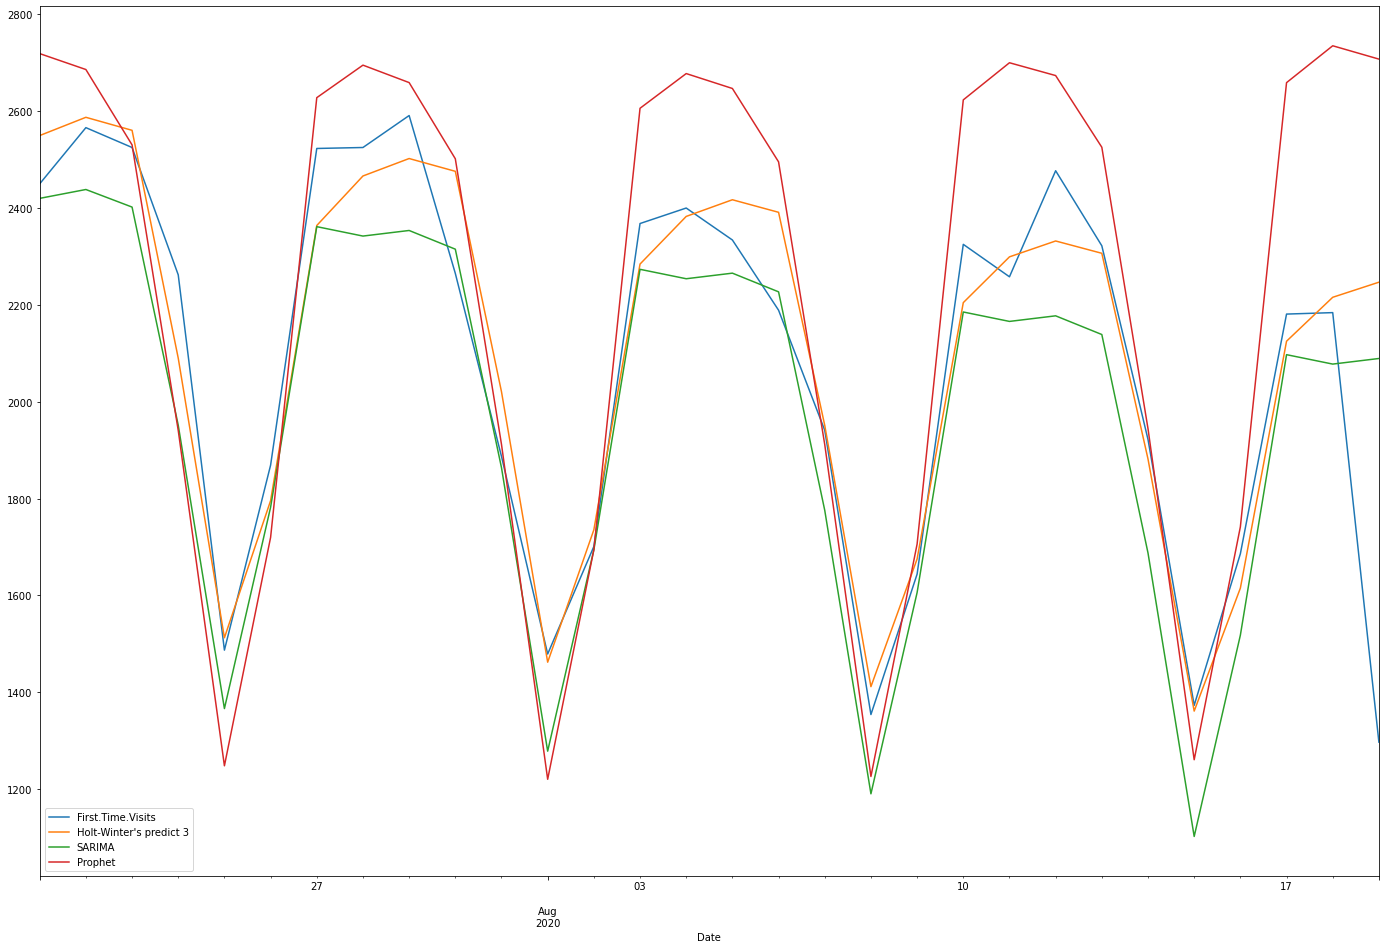

In [63]:
test_data.plot(legend = True)
fcastHoltWinter3_3.plot(legend = True)
fcastSARIMA3.plot(legend = True)
prophetForecast3['Prophet'].plot(legend = True)

##### Holt-Winter's method is once again the best. Sarima undervalues points every time, while prophet goes too far in both directions.

### Final forecast for 30 days into the future

In [69]:
#Holt-Winter's method
fitHoltWinter3_3 = ExponentialSmoothing(df1, trend = 'add', seasonal = 'mul', seasonal_periods = 7).fit()
fcastHoltWinter3_3 = fitHoltWinter3_3.forecast(30).rename("Holt-Winter's predict")

#SARIMA
fitSARIMA3 = SARIMAX(df1, order = (1, 1, 2), seasonal_order = (1, 0, 1, 7)).fit()
start = len(df1)
end = start + 29
fcastSARIMA3 = fitSARIMA3.predict(start = start, end = end, dynamic = False).rename('SARIMA')

#Prophet
data = df1.reset_index()[['Date', 'First.Time.Visits']]
data.columns = ['ds', 'y']
fitProphet = Prophet(weekly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(30)
fcastProphet = fitProphet.predict(future)

#going back to normal dataframe from prophet
prophetForecast3 = fcastProphet[['ds', 'yhat']].iloc[-30:]
prophetForecast3.set_index('ds', inplace = True)
prophetForecast3.index.name = 'Date'
prophetForecast3.columns = ['Prophet']
prophetForecast3.index.freq = 'D'

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='Date'>

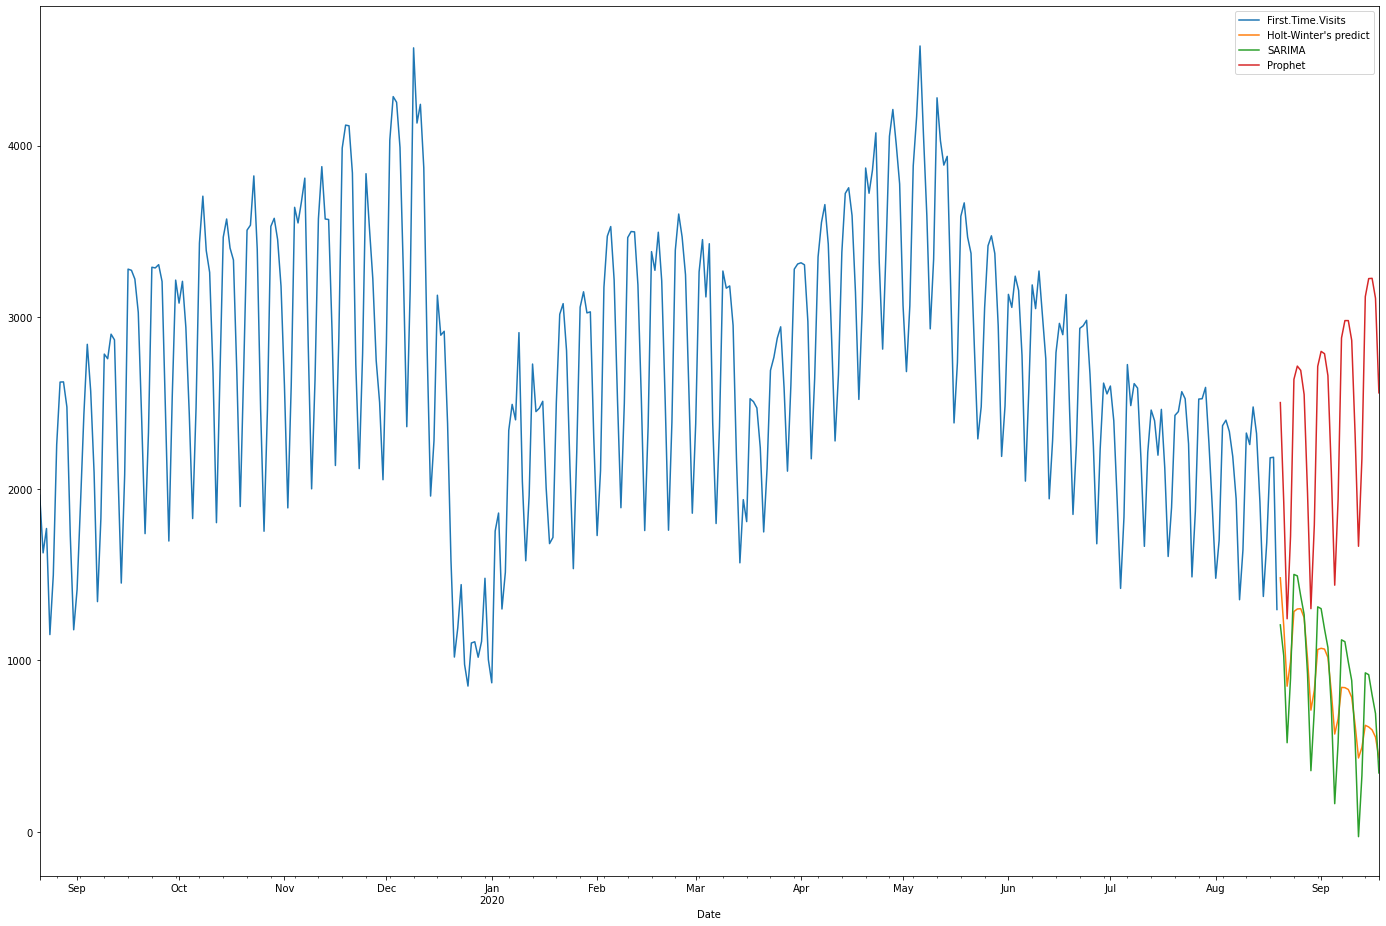

In [71]:
df1.tail(365).plot(legend = True)
fcastHoltWinter3_3.plot(legend = True)
fcastSARIMA3.plot(legend = True)
prophetForecast3['Prophet'].plot(legend = True)

### Even though Holt-Winter's method had the lowest MAPE it doesnt matter for the final forecast, since it doesn't take into account the yearly trend. Same thing happens with SARIMA. At this point i'm almost certain that no matter what I type into prophet it automatically searches for seasonal trends, taking them both into account - there seems to be no other explanation why it can go up otherwise, giving it the best forecast across all models i investigated today.